In [1]:
import efficientnet

In [2]:
import os 
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [131]:
# resizing the image
Size_X =240
Size_Y =240
n_classes = 2

In [132]:
#capturing training image info as a list
train_images = []
for dir_path in glob.glob('new/train_data/train_img/liver/'):
  for img_path in sorted(glob.glob(os.path.join(dir_path+'*.jpg'))):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
    img = cv2.resize(img, (Size_Y, Size_X))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    train_images.append(img/255.0)
 
train_images = np.array(train_images)
count = 0
train_masks = [] 
for dir_path in glob.glob('new/train_data/train_img/mask/'):
    for mask_path in sorted(glob.glob(os.path.join(dir_path+'*.tiff'))):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (Size_Y, Size_X))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
      
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [133]:
train_masks.shape

(14605, 240, 240)

In [4]:
#capturing testing/validation image info as a list
test_images = []
for dir_path in glob.glob('new/test_data/test_img/vol/'):
  for img_path in sorted(glob.glob(os.path.join(dir_path+'*.jpg'))):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
    img = cv2.resize(img, (Size_Y, Size_X))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    test_images.append(img/255.0)
 
test_images = np.array(test_images)
count = 0
test_masks = [] 
for dir_path in glob.glob("new/test_data/test_img/mask/"):
    for mask_path in sorted(glob.glob(os.path.join(dir_path+'*.tiff'))):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (Size_Y, Size_X))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        test_masks.append(mask)
      
#Convert list to array for machine learning processing          
test_masks = np.array(test_masks)

In [134]:
#from keras.utils import normalize
import tensorflow as tf
import segmentation_models as sm
BACKBONE ="resnet50"
preprocess_input = sm.get_preprocessing(BACKBONE)

In [135]:
X=train_images
Y=train_masks
#Y[Y[:,:,:]==1]=0
#Y[Y[:,:,:]==2]=1
Y=np.expand_dims(Y,axis=3)
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X,Y, test_size=0.3)

In [ ]:
x_train = x_train.astype(np.float32)
x_val= x_val.astype(np.float32)
y_train=y_train.astype(np.float32)
y_val = y_val.astype(np.float32)

In [136]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], 3))
 
test_masks_cat = to_categorical(y_val)
y_test_cat = test_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], 3))

In [ ]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)


In [52]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [137]:
# define model

model = sm.PSPNet(BACKBONE, encoder_weights = None, classes =3 ,encoder_freeze=False, activation='softmax',input_shape=(Size_X,Size_Y,3), downsample_factor=8,psp_conv_filters=512, psp_pooling_type='avg',psp_use_batchnorm=True,psp_dropout=0.2)
#model = sm.Unet(BACKBONE, encoder_weights = 'imagenet', classes =3 ,encoder_freeze=False,input_shape=(256,256,3),activation='softmax')
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),loss=sm.losses.cce_jaccard_loss, metrics=[sm.metrics.IOUScore(class_indexes=2),sm.metrics.FScore(class_indexes=2),sm.metrics.Precision(class_indexes=2),sm.metrics.Recall(class_indexes=2)])
print(model.summary())


Model: "functional_49"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 240, 240, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_54 (ZeroPadding2 (None, 246, 246, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 120, 120, 64) 9408        zero_padding2d_54[0][0]          
______________________________________________________________________________________

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath = 'weights/new/psp_effb0.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [12]:
from livelossplot import PlotLossesKeras
#Include this as callback., but slows the training ()
hist=model.fit(
   x=x_train,
   y=y_train_cat,
   batch_size=16,
   epochs=30,
   verbose=1,
   validation_data=(x_val, y_test_cat),
   callbacks=[checkpoint],
)

2022-06-16 08:55:27.526354: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 7066137600 exceeds 10% of free system memory.
2022-06-16 08:55:32.966276: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 7066137600 exceeds 10% of free system memory.
2022-06-16 08:55:41.517363: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 7066137600 exceeds 10% of free system memory.
2022-06-16 08:55:47.448290: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 7066137600 exceeds 10% of free system memory.


Epoch 1/30
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:batch_all_reduce: 85 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 85 all-reduces with algorithm = nccl, num_packs = 1


2022-06-16 08:56:25.335463: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2022-06-16 08:56:29.364360: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


639/639 [==============================] - ETA: 0s - loss: 0.3653 - iou_score: 0.2221 - f1-score: 0.2982 - precision: 0.3322 - recall: 0.4863
Epoch 00001: val_loss improved from inf to 0.32555, saving model to weights/new/psp_effb0.h5
639/639 [==============================] - 59s 93ms/step - loss: 0.3653 - iou_score: 0.2221 - f1-score: 0.2982 - precision: 0.3322 - recall: 0.4863 - val_loss: 0.3256 - val_iou_score: 0.2964 - val_f1-score: 0.3855 - val_precision: 0.4952 - val_recall: 0.5352
Epoch 2/30
639/639 [==============================] - ETA: 0s - loss: 0.2753 - iou_score: 0.3767 - f1-score: 0.4702 - precision: 0.4987 - recall: 0.6390
Epoch 00002: val_loss improved from 0.32555 to 0.25731, saving model to weights/new/psp_effb0.h5
639/639 [==============================] - 44s 68ms/step - loss: 0.2753 - iou_score: 0.3767 - f1-score: 0.4702 - precision: 0.4987 - recall: 0.6390 - val_loss: 0.2573 - val_iou_score: 0.4113 - val_f1-score: 0.5050 - val_precision: 0.5410 - val_recall: 0.68

Epoch 18/30
639/639 [==============================] - ETA: 0s - loss: 0.2170 - iou_score: 0.5178 - f1-score: 0.5988 - precision: 0.8299 - recall: 0.6052
Epoch 00018: val_loss did not improve from 0.18767
639/639 [==============================] - 45s 70ms/step - loss: 0.2170 - iou_score: 0.5178 - f1-score: 0.5988 - precision: 0.8299 - recall: 0.6052 - val_loss: 0.1948 - val_iou_score: 0.5742 - val_f1-score: 0.6549 - val_precision: 0.8073 - val_recall: 0.6800
Epoch 19/30
639/639 [==============================] - ETA: 0s - loss: 0.1983 - iou_score: 0.5596 - f1-score: 0.6436 - precision: 0.8122 - recall: 0.6595
Epoch 00019: val_loss did not improve from 0.18767
639/639 [==============================] - 45s 70ms/step - loss: 0.1983 - iou_score: 0.5596 - f1-score: 0.6436 - precision: 0.8122 - recall: 0.6595 - val_loss: 0.2197 - val_iou_score: 0.5105 - val_f1-score: 0.5908 - val_precision: 0.8429 - val_recall: 0.5776
Epoch 20/30
639/639 [==============================] - ETA: 0s - loss: 0

In [138]:
model.load_weights('weights/new/PSP240_resnet50.h5')

In [80]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
U=train_images
V=train_masks
V = np.expand_dims(V, axis=3)
test_masks_cat = to_categorical(V)
v_train_cat = test_masks_cat.reshape((V.shape[0], V.shape[1], V.shape[2], 3))

In [114]:
results = model.evaluate(U,v_train_cat,batch_size=1)
print(results)

14605/14605 [==============================] - 196s 13ms/step - loss: nan - iou_score: 0.8104 - f1-score: 0.8184 - precision: 0.8259 - recall: 0.9699
[nan, 0.8103866577148438, 0.8183714151382446, 0.8259307742118835, 0.9698696732521057]


(1, 240, 240, 3)
inference time is:77.82483100891113ms


[]

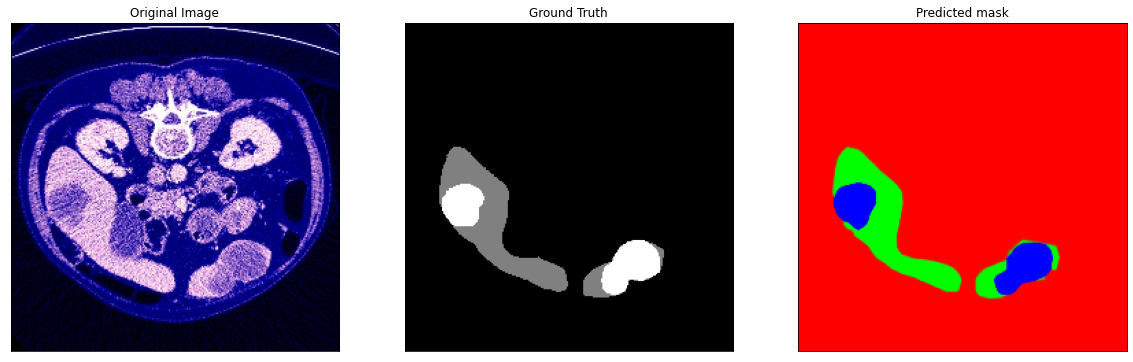

In [142]:
import time
#Test on a different image
#READ EXTERNAL IMAGE...
start =time.time()
test_img = cv2.imread('new/train_data/train_img/liver/volume-129_slice_104.jpg', cv2.IMREAD_COLOR)       
test_img = cv2.resize(test_img, (Size_Y, Size_X))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_img1 = np.expand_dims(test_img, axis=0)
print(test_img1.shape)
test_img1=test_img1/255.0
start =time.time()
prediction = model.predict(test_img1)
img=prediction.reshape((Size_Y, Size_X,3))
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
end=time.time()
inference=(end-start)*1000
print("inference time is:"+str(inference)+"ms")

mask_img = cv2.imread('new/train_data/train_img/mask/segmentation-129_slice_104.tiff',0)       
mask_img = cv2.resize(mask_img, (Size_Y, Size_X))
fig, ax= plt.subplots(1,3,figsize=(20, 20))
ax[0].imshow(test_img, cmap='gray')
ax[0].set(title='Original Image')
ax[0].xaxis.set_ticks([])
ax[0].yaxis.set_ticks([])
ax[1].imshow(mask_img, cmap='gray')
ax[1].set(title='Ground Truth')
ax[1].xaxis.set_ticks([])
ax[1].yaxis.set_ticks([])
ax[2].imshow(img, cmap='gray')
ax[2].set(title='Predicted mask')
ax[2].xaxis.set_ticks([])
ax[2].yaxis.set_ticks([])
 

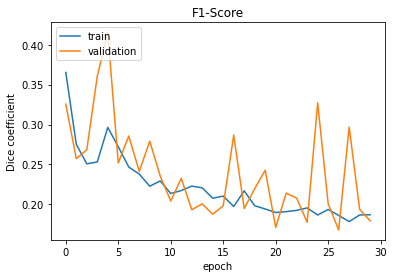

In [128]:

def plot_hist(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("F1-Score")
    plt.ylabel("Dice coefficient")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [ ]:
import os
import pandas as pd

In [ ]:
vol_list = []
mask_list = []
for filename in sorted(os.listdir('new/train_data/vol')):
    vol_list.append(filename)
for filename in sorted(os.listdir('new/train_data/mask')):
    mask_list.append(filename)

df_files = pd.DataFrame(vol_list,columns=['volname'])
df_files['maskname'] = mask_list

In [ ]:
rows = len(df_files)
train_img=[]
train_mask=[]
dir_path = "new/"
for i in range(0,rows):
  vol_path=os.path.join(dir_path+'train_frames/'+df_files['volname'][i])
  mask_path=os.path.join(dir_path+'train_masks/'+df_files['maskname'][i])
  curr_mask = cv2.imread(mask_path,0)
  if(1 in np.unique(curr_mask)):
        img = cv2.imread(vol_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (Size_Y, Size_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        mask = cv2.resize(curr_mask, (Size_Y, Size_X))
        train_img.append(img)
        train_mask.append(mask)
  
train_img = np.array(train_img)
train_mask = np.array(train_mask)


In [ ]:
train_img.shape

# Training only for tumor

In [ ]:
# define model
model = sm.PSPNet(BACKBONE, encoder_weights = 'imagenet', classes =1 ,encoder_freeze=False, activation='sigmoid',input_shape=(Size_X,Size_Y,3), downsample_factor=8,psp_conv_filters=512, psp_pooling_type='avg',psp_use_batchnorm=True,psp_dropout=0.2)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),loss=sm.losses.JaccardLoss(), metrics=[sm.metrics.IOUScore(),sm.metrics.FScore(),sm.metrics.Precision(),sm.metrics.Recall()],)
print(model.summary())

In [ ]:
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
filepath = 'weights/effb4_240_tumor2.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
from livelossplot import PlotLossesKeras
#Include this as callback., but slows the training ()
hist=model.fit(
   x=x_train,
   y=y_train,
   batch_size=8,
   epochs=20,
   verbose=1,
   validation_data=(x_val, y_val),
   callbacks=[checkpoint],
)